# A Google Meridian PyMC-Marketing Comparison

## Enterprise Dataset

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # visible in this process + all children
os.environ['JAX_PLATFORMS']='cpu'

# Standard imports
import re
import time
import warnings

import pickle

# IPython and Jupyter-specific
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

# Third-party imports
import arviz as az
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
import xarray as xr
from pympler import asizeof
from statsmodels.stats.stattools import durbin_watson

import nutpie

# PyMC Marketing
from pymc_marketing.mmm import GeometricAdstock, LogisticSaturation, HillSaturationSigmoid
from pymc_marketing.mmm.multidimensional import (
    MMM,
    MultiDimensionalBudgetOptimizerWrapper,
)
from pymc_marketing.prior import Prior

# Meridian
from meridian import constants
from meridian.analysis import analyzer, formatter, optimizer, summarizer, visualizer
from meridian.data import (
    data_frame_input_data_builder,
    input_data,
    load,
    test_utils,
)
from meridian.model import model, prior_distribution, spec

# Data generation
from mmm_param_recovery.data_generator import (
    generate_mmm_dataset,
    get_preset_config,
)


# Warnings and plotting style
warnings.filterwarnings("ignore", category=UserWarning)
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 8
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


import pytensor
print("PyTensor BLAS flags:", pytensor.config.blas__ldflags)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/opt/miniconda3/envs/python312-cpu/lib/python3.12/site-packages/pymc_marketing/mmm/multidimensional.py:72: FutureWarning: This functionality is experimental and subject to change. If you encounter any issues or have suggestions, please raise them at: https://github.com/pymc-labs/pymc-marketing/issues/new
  warnings.warn(warning_msg, FutureWarning, stacklevel=1)


Num GPUs Available:  0
PyTensor BLAS flags: -framework Accelerate -Wl,-rpath,/opt/miniconda3/envs/python312-cpu/lib


In [2]:
# Set random seed for reproduceability
seed: int = sum(map(ord, "mmm_multidimensional"))
rng: np.random.Generator = np.random.default_rng(seed=seed)
tf.keras.utils.set_random_seed(seed)

## The Data

A description of the data

In [3]:
dataset_names= ["small_business"]

In [4]:
datasets = []
channel_columns_list = []
truth_dfs = []

for name in dataset_names:
    # Check if data already exists
    data_path = f"data/results/{name}"
    data_file = f"{data_path}/data.pkl"
    
    if os.path.exists(data_file):
        print(f"Loading existing data for {name}")
        with open(data_file, 'rb') as f:
            business_result = pickle.load(f)
    else:
        print(f"Generating new data for {name}")
        business_config = get_preset_config(name.split("-",1)[0])
        business_result = generate_mmm_dataset(business_config)
        
        # Save the business result for future use
        os.makedirs(data_path, exist_ok=True)
        with open(data_file, 'wb') as f:
            pickle.dump(business_result, f)
    
    data_df = business_result['data'].rename(columns = {"date": "time"})
    print(f"{name.replace('_', ' ').title()} dataset shape: {data_df.shape}")
    data_df["population"] = 1
    print(f"Regions: {data_df['geo'].unique()}")
    print(f"Date range: {data_df['time'].min()} to {data_df['time'].max()}")
    print("")
    print("="*20)
    print("")
    datasets.append(data_df)
    channel_columns_list.append([col for col in data_df.columns if re.match(r"x\d+", col)])
    truth_dfs.append(business_result['ground_truth']['transformed_spend'].reset_index().rename(columns={"date": "time"}))


Loading existing data for small_business
Small Business dataset shape: (104, 11)
Regions: ['Local']
Date range: 2020-01-05 00:00:00 to 2021-12-26 00:00:00




## Data Pre-Processing

In [5]:
# Meridian

# Storage for built data objects
built_data_objects = []

for data_df, channel_columns in zip(datasets, channel_columns_list):
    # Detect control columns in the form of 'c1', ..., 'cN' if present
    potential_controls = ['c' + str(idx) for idx in range(data_df.shape[1])]
    control_cols = [col for col in potential_controls if col in data_df.columns]

    # Start building the data input
    builder = (
        data_frame_input_data_builder.DataFrameInputDataBuilder(kpi_type='revenue')
        .with_kpi(data_df, kpi_col="y")
        .with_population(data_df)
    )

    # Add controls only if any are found
    if control_cols:
        builder = builder.with_controls(data_df, control_cols=control_cols)

    # Add media columns
    builder = builder.with_media(
        data_df,
        media_cols=channel_columns,
        media_spend_cols=channel_columns,
        media_channels=channel_columns,
    )

    # Finalize the builder and store the result
    built_data = builder.build()
    built_data_objects.append(built_data)

# PyMC-Marketing
# None required.

## Prior Specification 

**Meridian**

- Uses spend share as prior variance for $\beta$ parameters, across channels - does not allow for geo level.
- Hierarchical structure accross the saturation parameters - Meridian does this by default.
- Setting knots to occur every 26 weeks, to best align with seasonality of order 2.

**PyMC-Marketing**

- Using spend share as prior for $\beta$ parameters, across channels and geos.
- Hierarchical structure accross the saturation parameters.
- Includes fourier seasonality of order 2.

In [6]:
spend_share_list = []
prior_sigma_list = []

for data_df, channel_columns in zip(datasets, channel_columns_list):
    n_channels = len(channel_columns)

    # Group and sum media spend by geo
    sum_spend_geo_channel = data_df.groupby("geo")[channel_columns].sum()

    # Calculate spend share
    spend_share = (
        sum_spend_geo_channel.to_numpy() /
        sum_spend_geo_channel.sum(axis=1).to_numpy()[:, None]
    )

    # Calculate prior sigma
    prior_sigma = n_channels * spend_share

    # Store results
    prior_sigma_list.append(prior_sigma)


In [7]:
meridian_priors = []
pymc_saturation_objects = []

for data, channel_columns, prior_sigma in zip(built_data_objects, channel_columns_list, prior_sigma_list):
    # Meridian setup
    n_time = len(data.time)
    knots = np.arange(0, n_time, 26).tolist()

    build_media_channel_args = data.get_paid_media_channels_argument_builder()

    beta_m = build_media_channel_args(
        **{
            col: (0, float(prior_sigma.mean(axis=0)[i]))
            for i, col in enumerate(channel_columns)
        }
    )

    beta_m_mu, beta_m_sigma = zip(*beta_m)

    prior = prior_distribution.PriorDistribution(
        beta_m=tfp.distributions.LogNormal(
            beta_m_mu, beta_m_sigma, name=constants.BETA_M
        )
    )
    meridian_priors.append(prior)

    # PyMC-Marketing setup

    saturation = HillSaturationSigmoid(
        priors = {
            "sigma":  Prior(
                "InverseGamma",
                mu=Prior("HalfNormal", sigma=prior_sigma.mean(axis=0), dims = ("channel",)),
                sigma=Prior("HalfNormal", sigma=1.5),
                dims=("channel", "geo")),
            "beta": Prior("HalfNormal", sigma=1.5, dims = ("channel",)),
            "lam":  Prior("HalfNormal", sigma=1.5, dims = ("channel",)),
        },
    )

    pymc_saturation_objects.append(saturation)

## Model Specification

**Meridian**

This is a geo-level model with the following specification:

$$
y_{g,t} = \mu_{t} +\tau_{g} + \sum_{i=1}^{N_C} \gamma^{[C]}_{g,i} z_{g,t,i} 
+ \sum_{i=1}^{N_M} \beta^{[M]}_{g,i} \text{HillAdstock} \left( \{ x^{[M]}_{g,t-s,i} \}_{s=0}^{L} ; \alpha^{[M]}_i, ec^{[M]}_{i}, slope^{[M]}_{i} \right) + \epsilon_{g,t}
$$

Where:

- $\mu_{t}$ represents the intercept at time $t$.
- $\tau_{g}$ represents the intercept for geo $g$.
- $\sum_{i=1}^{N_C} \gamma^{[C]}_{g,i} z_{g,t,i}$ represents the control contribution at time $t$ for geo $g$.
- $\sum_{i=1}^{N_M} \beta^{[M]}_{g,i} \text{HillAdstock} \left( \{ x^{[M]}_{g,t-s,i} \}_{s=0}^{L} ; \alpha^{[M]}_i, ec^{[M]}_{i}, slope^{[M]}_{i} \right)$ represents the adstocked saturated media contribution at time $t$ for geo $g$.
- $\epsilon_{g,t}$ represents the error at time $t$ for geo $g$

----

**PyMC-Marketing**

This is a geo-level model with the following specification:

$$
y_{g,t} = \mu_g + \sum_{i=0}^{4} \gamma^{[F]}_{g,i} f_{g,t,i} 
+ \sum_{i=1}^{N_C} \gamma^{[C]}_{g,i} z_{g,t,i} 
+ \sum_{i=1}^{N_M} \sigma^{[M]}_{g,i} \text{HillAdstock} \left( \{ x^{[M]}_{g,t-s,i} \}_{s=0}^{L} ; \alpha^{[M]}_i, \lambda^{[M]}_{i}, \beta^{[M]}_{i}\right) + \epsilon_{g,t}
$$

Where:

- $\mu_g$ represents the intercept for geo g.
- $\sum_{i=0}^{4} \gamma^{[F]}_{g,i} f_{g,t,i}$ represents the seasonality/fourier contribution (order 2) at time $t$ for geo $g$.
- $\sum_{i=1}^{N_C} \gamma^{[C]}_{g,i} z_{g,t,i}$ represents the control contribution at time $t$ for geo $g$.
- $\sum_{i=1}^{N_M} \sigma^{[M]}_{g,i} \text{HillAdstock} \left( \{ x^{[M]}_{g,t-s,i} \}_{s=0}^{L} ; \alpha^{[M]}_i, \lambda^{[M]}_{i}, \beta^{[M]}_{i}\right)$ represents the adstocked saturated media contribution at time $t$ for geo $g$.
- $\epsilon_{g,t}$ represents the error at time $t$ for geo $g$

In [8]:
meridian_model_specs = []
pymc_mmm_models = []

for data_df, data, channel_columns, prior, saturation in zip(
    datasets,
    built_data_objects,
    channel_columns_list,
    meridian_priors,
    pymc_saturation_objects
):
    # Detect existing control columns (c1 to cN)
    potential_controls = ['c'+ str(i) for i in range(len(data_df.columns))]
    control_columns = [col for col in potential_controls if col in data_df.columns]
    
    # Meridian: model spec
    n_time = len(data.time)
    knots = np.arange(0, n_time, 26).tolist()

    model_spec = spec.ModelSpec(
        prior=prior,
        media_effects_dist='log_normal',
        hill_before_adstock=False,
        max_lag=8,
        unique_sigma_for_each_geo=True,
        roi_calibration_period=None,
        rf_roi_calibration_period=None,
        knots=knots,
        baseline_geo=None,
        holdout_id=None,
        control_population_scaling_id=None,
        media_prior_type='coefficient',
        rf_prior_type='coefficient',
    )
    meridian_model_specs.append(model_spec)

    # PyMC-Marketing: MMM model
    mmm = MMM(
        date_column="time",
        target_column="y",
        channel_columns=channel_columns,
        control_columns=control_columns,
        dims=("geo",),
        scaling={
            "channel": {"method": "max", "dims": ()},
            "target": {"method": "max", "dims": ()},
        },
        saturation=saturation,
        adstock=GeometricAdstock(
            l_max=8,
            priors={"alpha": Prior("Beta", alpha=1, beta=3, dims=("channel",))},
        ),
        yearly_seasonality=2,
    )
    pymc_mmm_models.append(mmm)


## Model Building

In [9]:
meridian_models = []
pymc_built_models = []

for data_df, data, model_spec, mmm in zip(
    datasets,
    built_data_objects,
    meridian_model_specs,
    pymc_mmm_models
):
    # --- Meridian ---
    meridian_instance = model.Meridian(input_data=data, model_spec=model_spec)
    meridian_models.append(meridian_instance)

    # --- PyMC-Marketing ---
    x_train = data_df.drop(columns=["y"])
    y_train = data_df["y"]

    mmm.build_model(X=x_train, y=y_train)

    # Base contribution variables
    contribution_vars = [
        "channel_contribution",
        "intercept_contribution",
        "yearly_seasonality_contribution",
        "y",
    ]

    # Add control contribution only if controls exist
    if any(col in data_df.columns for col in ["c1", "c2", "c3", "c4"]):
        contribution_vars.insert(1, "control_contribution")

    mmm.add_original_scale_contribution_variable(var=contribution_vars)

    pymc_built_models.append(mmm)

## Prior Sampling

In [10]:
meridian_prior_samples = []
pymc_prior_predictives = []
pymc_scalers = []

for meridian_model, mmm_model, data_df in zip(
    meridian_models,
    pymc_built_models,
    datasets
):
    # --- Meridian ---
    meridian_model.sample_prior(1000)
    meridian_prior_samples.append(meridian_model)

    # --- PyMC-Marketing ---
    x_train = data_df.drop(columns=["y"])
    y_train = data_df["y"]

    prior_predictive = mmm_model.sample_prior_predictive(X=x_train, y=y_train, samples=1000)
    scalers = mmm_model.get_scales_as_xarray()

    pymc_prior_predictives.append(prior_predictive)
    pymc_scalers.append(scalers)

Sampling: [adstock_alpha, gamma_control, gamma_fourier, intercept_contribution, saturation_beta, saturation_lam, saturation_sigma, saturation_sigma_mu, saturation_sigma_sigma, y, y_sigma]


## Posterior Sampling
We aim to observe the following:
- Speed comparisons
- Memory comparisons
- Convergence analysis

In [51]:
# Main sampling with caching
SAMPLERS = ["pymc", "blackjax", "numpyro", "nutpie"]
FORCE_RERUN = True

NTUNE = 1_000
NDRAW = 1_000

N_CHAINS = 4

TARGET_ACCEPT = 0.9

In [52]:
import pickle
from pathlib import Path
from meridian.model import model as meridian_model_module
from copy import deepcopy
from collections import defaultdict
from pymc_marketing.mmm import MMM

# Simplified model caching functions
def get_paths(dataset_name, library, sampler=None):
    """Get model and stats paths"""
    dir = Path(f"data/results/{dataset_name}")
    dir.mkdir(parents=True, exist_ok=True)
    
    suffix = f"_{sampler}" if sampler else ""
    model_ext = ".pkl" if library.lower() == "meridian" else ".nc"
    
    return (
        dir / f"{library}{suffix}_model{model_ext}",
        dir / f"{library}{suffix}_stats.pkl"
    )

def model_exists(dataset_name, library, sampler=None):
    """Check if model exists"""
    model_path, stats_path = get_paths(dataset_name, library, sampler)
    return model_path.exists() and stats_path.exists()

def save_model(model_obj, dataset_name, library, sampler, runtime, ess_stats):
    """Save model and statistics safely for both PyMC-Marketing and Meridian."""
    model_path, stats_path = get_paths(dataset_name, library, sampler)

    # Save model according to library
    if library.lower() == "meridian":
        meridian_model_module.save_mmm(model_obj, str(model_path))
    else:
        model_obj.save(str(model_path))

    # Save statistics
    with open(stats_path, 'wb') as f:
        pickle.dump({'runtime': runtime, 'ess': ess_stats}, f)

    print(f"  ✓ Saved {library} - {sampler} model and diagnostics at {model_path}")


def load_model(dataset_name, library, sampler=None):
    """Load model and statistics from single NetCDF file for PyMC-Marketing."""
    model_path, stats_path = get_paths(dataset_name, library, sampler)

    # Load model according to library
    if library.lower() == "meridian":
        loaded_model = meridian_model_module.load_mmm(str(model_path))
    else:
        # Fallback to original MMM.load method
        loaded_model = MMM.load(str(model_path))

    # Load stats
    if os.path.isfile(stats_path):
        with open(stats_path, 'rb') as f:
            stats = pickle.load(f)
        print(f"  ✓ Loaded {library} - {sampler} from cache ({stats['runtime']:.1f}s)")
        return loaded_model, stats['runtime'], stats['ess']
    else:
        print(f"  ✗ Stats file not found: {stats_path}")
        return loaded_model, None, None

def compute_ess(idata):
    """Compute ESS stats from ArviZ output, aggregating finite values across variables."""
    try:
        es = az.ess(idata)
        arrays = []
        for v in es.data_vars:
            arr = np.asarray(es[v].values).astype(float)
            if arr.size == 0:
                continue
            arr = arr[np.isfinite(arr)]
            if arr.size == 0:
                continue
            arrays.append(arr.ravel())
        if not arrays:
            return {'min': None, 'q10': None, 'q50': None, 'q90': None}
        values = np.concatenate(arrays)
        return {
            'min': float(np.min(values)),
            'q10': float(np.quantile(values, 0.1)),
            'q50': float(np.quantile(values, 0.5)),
            'q90': float(np.quantile(values, 0.9))
        }
    except Exception as e:
        print(f"Warning: Could not compute ESS: {e}")
        return {'min': None, 'q10': None, 'q50': None, 'q90': None}



def fit_meridian_model(meridian_model, dataset_name, seed):
    """Fit a Meridian model and save the results"""
    print(f"Fitting Meridian model for {dataset_name} with seed {seed} N_ADAPT={NTUNE/2}, N_BURNIN={NTUNE/2}, N_KEEP={NDRAW}, TARGET_ACCEPT={TARGET_ACCEPT}")
    meridian_model = deepcopy(meridian_model)
    start = time.perf_counter()
    meridian_model.sample_posterior(
        n_chains=N_CHAINS, n_adapt=int(NTUNE/2), n_burnin=int(NTUNE/2), n_keep=NDRAW,
        seed=(seed, seed), dual_averaging_kwargs={"target_accept_prob": TARGET_ACCEPT}
    )
    runtime = time.perf_counter() - start
    ess = compute_ess(meridian_model.inference_data)
    save_model(meridian_model, dataset_name, "meridian", None, runtime, ess)
    
    print(f"  Meridian: {runtime:.1f}s")

    return meridian_model, runtime, ess

def fit_pymc_model(pyc_model_template, data_df, dataset_name, sampler, seed):
    print(f"Fitting PyMC-Marketing model for {dataset_name} with seed {seed} N_CHAINS={N_CHAINS}, N_DRAWS={NDRAW}, NTUNE={NTUNE}, TARGET_ACCEPT={TARGET_ACCEPT}")
    mmm_model = deepcopy(pyc_model_template)

    x, y = data_df.drop(columns=["y"]), data_df["y"]
    kwargs = {"nuts_sampler_kwargs": {"backend": "jax", "gradient_backend": "jax"}} if sampler == "nutpie" else {}
    
    start = time.perf_counter()
    mmm_model.fit(x, y, chains=N_CHAINS, draws=NDRAW, tune=NTUNE, target_accept=TARGET_ACCEPT,
                random_seed=seed, nuts_sampler=sampler, **kwargs)
    mmm_model.sample_posterior_predictive(x, extend_idata=True, combined=True, random_seed=seed)
    runtime = time.perf_counter() - start
    
    # Compute ESS on the full InferenceData (posterior), letting ArviZ handle dims/coords
    ess = compute_ess(mmm_model.idata)
    
    save_model(mmm_model, dataset_name, "pymc", sampler, runtime, ess)
    pymc_result = mmm_model

    return pymc_result, runtime, ess

# Storage
all_models = defaultdict(list)

run_times = defaultdict(list)
esss = defaultdict(list)

for i, (meridian_model, mmm_model, data_df) in enumerate(zip(
    meridian_models, pymc_built_models, datasets
)):
    dataset_name = dataset_names[i]
    print(f"\n--- {dataset_name} ---")
    
    # Add dataset to tracking lists (for compatibility)
    run_times["Dataset"].append(dataset_name)
    esss["Dataset"] += [dataset_name] * 4
    all_models['Dataset'].append(dataset_name)

    # Process Meridian
    
    if not FORCE_RERUN and model_exists(dataset_name, "meridian"):
        meridian_result, runtime, ess = load_model(dataset_name, "meridian") 
    else:
        try:
            meridian_result, runtime, ess = fit_meridian_model(meridian_model, dataset_name, seed)
        except Exception as e:
            print(f"  ✗ Meridian failed: {e}")
            meridian_result, runtime, ess = None, None, {'min': None, 'q10': None, 'q50': None, 'q90': None}
    
    all_models['Meridian'].append(meridian_result)
    run_times["Meridian"].append(runtime)
    esss["Meridian"] += [ess['min'], ess['q10'], ess['q50'], ess['q90']]
    
    # Process PyMC-Marketing samplers
    for sampler in SAMPLERS:
        # Skip memory-intensive combinations
        if sampler in ["blackjax", "numpyro"] and "large" in dataset_name:
            print(f"  Skipping {sampler} for large dataset (memory)")
            continue
        
        if not FORCE_RERUN and model_exists(dataset_name, "pymc", sampler):
            pymc_result, runtime, ess = load_model(dataset_name, "pymc", sampler)
            print(f"  PyMC-{sampler}: cached ({runtime:.1f}s)")
        else:
            pymc_result, runtime, ess = fit_pymc_model(mmm_model, data_df, dataset_name, sampler, seed)
        
        all_models[f'PyMC-Marketing - {sampler}'].append(pymc_result)
        run_times[f'PyMC-Marketing - {sampler}'].append(runtime)
        esss[f'PyMC-Marketing - {sampler}'] += [ess['min'], ess['q10'], ess['q50'], ess['q90']]

# Create backwards-compatible DataFrames
runtime_df = pd.DataFrame(run_times)
runtime_df.set_index("Dataset", inplace=True)
ess_df = pd.DataFrame(esss)


--- small_business ---
Fitting Meridian model for small_business with seed 2148 N_ADAPT=500.0, N_BURNIN=500.0, N_KEEP=1000, TARGET_ACCEPT=0.9
  ✓ Saved meridian - None model and diagnostics at data/results/small_business/meridian_model.pkl
  Meridian: 65.9s
Fitting PyMC-Marketing model for small_business with seed 2148 N_CHAINS=4, N_DRAWS=1000, NTUNE=1000, TARGET_ACCEPT=0.9


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept_contribution, adstock_alpha, saturation_sigma_mu, saturation_sigma_sigma, saturation_sigma, saturation_beta, saturation_lam, gamma_control, gamma_fourier, y_sigma]
/opt/miniconda3/envs/python312-cpu/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/opt/miniconda3/envs/python312-cpu/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


Output()

Sampling: [y]


Output()

  ✓ Saved pymc - pymc model and diagnostics at data/results/small_business/pymc_pymc_model.nc
Fitting PyMC-Marketing model for small_business with seed 2148 N_CHAINS=4, N_DRAWS=1000, NTUNE=1000, TARGET_ACCEPT=0.9
Running window adaptation


Output()

Sampling: [y]


Output()

  ✓ Saved pymc - blackjax model and diagnostics at data/results/small_business/pymc_blackjax_model.nc
Fitting PyMC-Marketing model for small_business with seed 2148 N_CHAINS=4, N_DRAWS=1000, NTUNE=1000, TARGET_ACCEPT=0.9


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Sampling: [y]


Output()

  ✓ Saved pymc - numpyro model and diagnostics at data/results/small_business/pymc_numpyro_model.nc
Fitting PyMC-Marketing model for small_business with seed 2148 N_CHAINS=4, N_DRAWS=1000, NTUNE=1000, TARGET_ACCEPT=0.9


Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,2,0.13,63
,2000,6,0.14,63
,2000,1,0.13,31
,2000,1,0.13,31


Output()

Sampling: [y]


Output()

  ✓ Saved pymc - nutpie model and diagnostics at data/results/small_business/pymc_nutpie_model.nc


In [53]:
display(runtime_df)

,Meridian,PyMC-Marketing - pymc,PyMC-Marketing - blackjax,PyMC-Marketing - numpyro,PyMC-Marketing - nutpie
Dataset,,,,,
small_business,65.911268,34.468105,14.828515,12.946436,28.420621


In [54]:
model =  all_models['PyMC-Marketing - nutpie'][0]
# compute_ess(mmm_model.idata)

In [55]:
df = ess_df.melt(id_vars = "Dataset")
df["ESS"] = ["min", "5%", "50%", "95%"] * 5 * len(dataset_names)
df.rename(columns={"variable":"Sampler"}).pivot(index = ["Dataset", "Sampler"], columns="ESS", values = "value").sort_values(by="min", ascending=False).round(2)

ESS                                            5%      50%      95%      min
Dataset        Sampler                                                      
small_business Meridian                   1360.89  1757.38  4000.00  1301.68
               PyMC-Marketing - blackjax  2515.60  3392.45  4000.00  1156.50
               PyMC-Marketing - pymc      2093.11  3251.00  4000.00   886.76
               PyMC-Marketing - numpyro   2580.81  3361.11  4148.03   840.70
               PyMC-Marketing - nutpie    1510.61  3336.51  4283.72   566.67

In [56]:
df = (ess_df.set_index("Dataset") / runtime_df).reset_index().melt(id_vars = "Dataset")
df["ESS / s"] = ["min", "5%", "50%", "95%"] * 5 * len(dataset_names)
df.rename(columns={"variable":"Sampler"}).pivot(index = ["Dataset", "Sampler"], columns="ESS / s", values = "value").sort_values(by="min", ascending=False).round(2)

ESS / s                                       5%     50%     95%    min
Dataset        Sampler                                                 
small_business PyMC-Marketing - blackjax  169.65  228.78  269.75  77.99
               PyMC-Marketing - numpyro   199.35  259.62  320.40  64.94
               PyMC-Marketing - pymc       60.73   94.32  116.05  25.73
               PyMC-Marketing - nutpie     53.15  117.40  150.73  19.94
               Meridian                    20.65   26.66   60.69  19.75

**Note** PyMC-Marketing stores the data and contributions as a part of the model object, meridian does not.

In [57]:
all_models = pd.DataFrame(all_models)

In [58]:
for i, dataset_name in enumerate(dataset_names):
    print(f"\n--- Dataset {i+1} ({dataset_name}) ---")

    # Meridian model size
    meridian_model = all_models['Meridian'][i]
    meridian_size = asizeof.asizeof(meridian_model)
    print(f"Meridian model size: {meridian_size / (1024 ** 2):.2f} MB")

    # PyMC-Marketing model sizes for all samplers
    for sampler in ['pymc', 'blackjax', 'numpyro', 'nutpie']:
        mmm_model = all_models[f'PyMC-Marketing - {sampler}'][i]
        pymc_size = asizeof.asizeof(mmm_model)
        print(f"PyMC-Marketing - {sampler} model size: {pymc_size / (1024 ** 2):.2f} MB")



--- Dataset 1 (small_business) ---
Meridian model size: 3.67 MB
PyMC-Marketing - pymc model size: 153.58 MB
PyMC-Marketing - blackjax model size: 153.23 MB
PyMC-Marketing - numpyro model size: 153.27 MB
PyMC-Marketing - nutpie model size: 159.51 MB


In [59]:
for i, dataset_name in enumerate(dataset_names):
    print(f"\n--- Dataset {i+1} ({dataset_name}) ---")

    # --- Meridian Diagnostics ---
    meridian_model = all_models['Meridian'][i]
    try:
        divergences = meridian_model.inference_data.sample_stats.diverging.sum().item()
        print(f"Meridian number of divergences: {divergences}")
    except AttributeError:
        print("Meridian divergences: Unable to access sample_stats")

    try:
        meridian_rhat_max = az.summary(
            meridian_model.inference_data,
            var_names=[
                "alpha_m", "beta_gm", "beta_m", "ec_m",
                "gamma_c", "gamma_gc", "sigma", "tau_g",
                "xi_c", "knot_values", "mu_t"
            ]
        )['r_hat'].max()
        print(f"Meridian maximum r_hat: {meridian_rhat_max:.3f}")
        
        # Calculate number of variables with divergent behavior
        meridian_summary = az.summary(
            meridian_model.inference_data,
            var_names=[
                "alpha_m", "beta_gm", "beta_m", "ec_m",
                "gamma_c", "gamma_gc", "sigma", "tau_g",
                "xi_c", "knot_values", "mu_t"
            ]
        )
        meridian_vars_with_divergences = (meridian_summary['r_hat'] > 1.1).sum()
        print(f"Meridian variables with r_hat > 1.1: {meridian_vars_with_divergences}")
    except Exception as e:
        print(f"Meridian r_hat: Unable to calculate ({str(e)})")

    # --- PyMC-Marketing Diagnostics for all samplers ---
    for sampler in ['pymc', 'blackjax', 'numpyro', 'nutpie']:
        mmm_model = all_models[f'PyMC-Marketing - {sampler}'][i]
        print(f"\n  --- PyMC-Marketing - {sampler} ---")
        
        try:
            # Check if the idata has posterior samples
            if hasattr(mmm_model.idata, 'posterior'):
                divergences = mmm_model.idata.sample_stats.diverging.sum().item()
                print(f"  Number of divergences: {divergences}")
            else:
                print("  No posterior samples found")
        except AttributeError:
            print("  Divergences: Unable to access sample_stats")
        except Exception as e:
            print(f"  Divergences: Error ({str(e)})")

        try:
            pymc_summary = az.summary(
                mmm_model.idata,
                var_names=[
                    "adstock_alpha", "gamma_control", "gamma_fourier",
                    "intercept_contribution", "saturation_beta",
                    "saturation_lam", "saturation_sigma", "y_sigma"
                ]
            )
            pymc_rhat_max = pymc_summary['r_hat'].max()
            print(f"  Maximum r_hat: {pymc_rhat_max:.3f}")
            
            # Calculate number of variables with divergent behavior
            pymc_vars_with_divergences = (pymc_summary['r_hat'] > 1.1).sum()
            print(f"  Variables with r_hat > 1.1: {pymc_vars_with_divergences}")
        except Exception as e:
            print(f"  r_hat: Unable to calculate ({str(e)})")



--- Dataset 1 (small_business) ---
Meridian number of divergences: 0


/opt/miniconda3/envs/python312-cpu/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/miniconda3/envs/python312-cpu/lib/python3.12/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


Meridian maximum r_hat: 1.000


/opt/miniconda3/envs/python312-cpu/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/miniconda3/envs/python312-cpu/lib/python3.12/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


Meridian variables with r_hat > 1.1: 0

  --- PyMC-Marketing - pymc ---
  Number of divergences: 7
  Maximum r_hat: 1.010
  Variables with r_hat > 1.1: 0

  --- PyMC-Marketing - blackjax ---
  Number of divergences: 0
  Maximum r_hat: 1.010
  Variables with r_hat > 1.1: 0

  --- PyMC-Marketing - numpyro ---
  Number of divergences: 4
  Maximum r_hat: 1.010
  Variables with r_hat > 1.1: 0

  --- PyMC-Marketing - nutpie ---
  Number of divergences: 10
  Maximum r_hat: 1.010
  Variables with r_hat > 1.1: 0


## Predictive Performance

In [60]:
# For backward compatibility
meridian_models = all_models['Meridian']

pymc_built_models = all_models['PyMC-Marketing - nutpie']

#### Meridian

In [61]:
for i, (mmm_model, data_df) in enumerate(zip(meridian_models, datasets), start=1):
    dataset_name = dataset_names[i - 1].split("_")[0]
    print(f"\n--- Plotting Posterior Predictive for Meridian model ({dataset_name}) ---")
    model_fit = visualizer.ModelFit(mmm_model) # 0 = small, 1 = medium and 2 = large
    fig = model_fit.plot_model_fit(
        n_top_largest_geos=len(data_df["geo"].unique()),
        show_geo_level=True,
        include_baseline=False,
        include_ci=True
    )
    fig.show()



--- Plotting Posterior Predictive for Meridian model (small) ---


alt.FacetChart(...)

#### PyMC-Marketing


--- Plotting Posterior Predictive for PyMC-Marketing model (small) ---


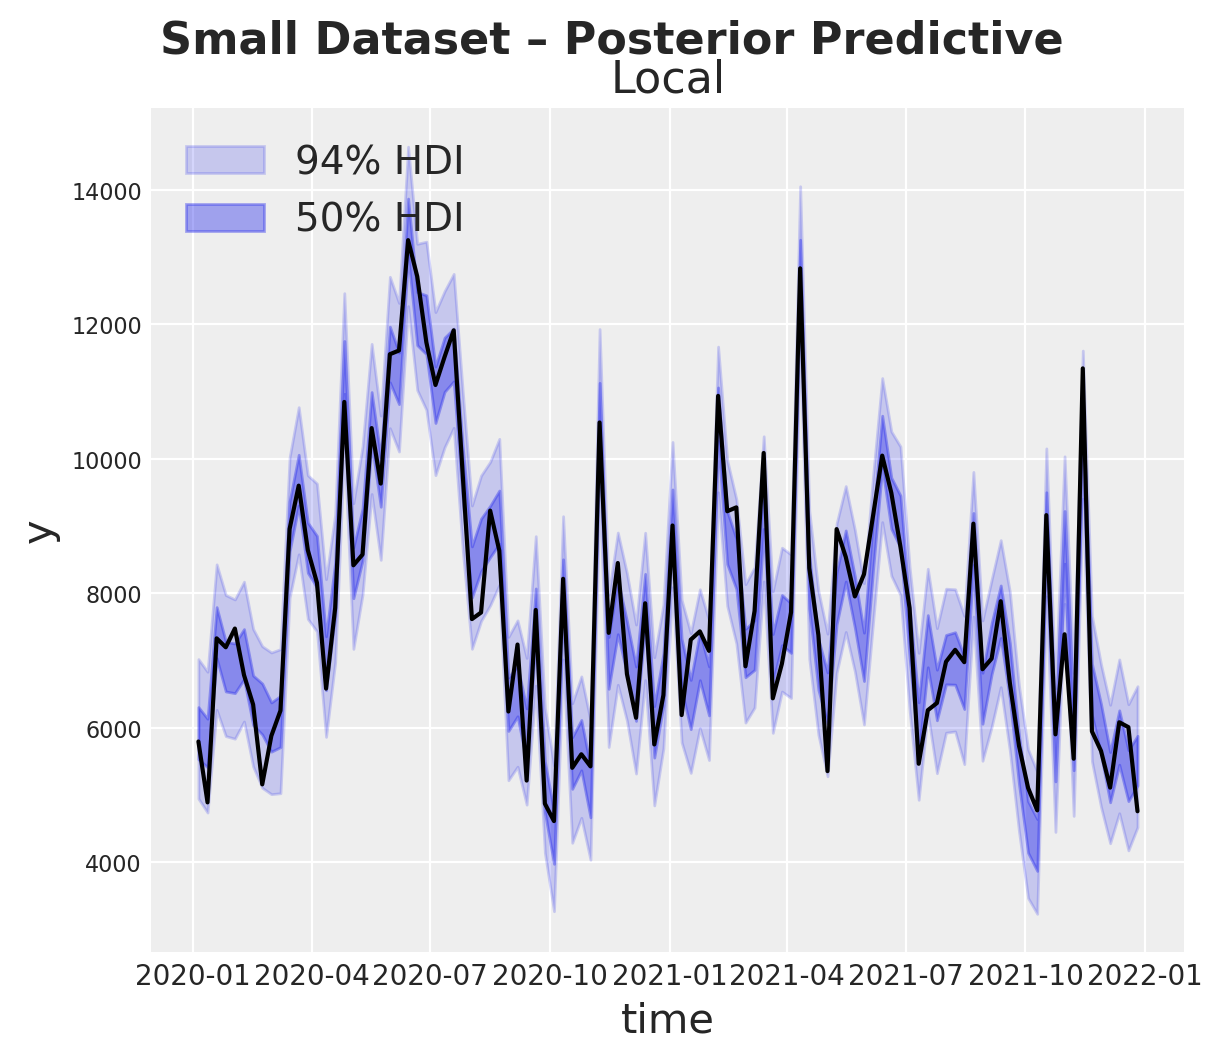

In [62]:
for i, (mmm_model, data_df) in enumerate(zip(pymc_built_models, datasets), start=1):
    dataset_name = dataset_names[i - 1].split("_")[0]
    print(f"\n--- Plotting Posterior Predictive for PyMC-Marketing model ({dataset_name}) ---")

    geos = mmm_model.model.coords["geo"]
    dates = mmm_model.model.coords["date"]

    fig, axes = plt.subplots(
        ncols=len(geos),
        figsize=(6 * len(geos), 5),
        sharex=True,
        sharey=True,
        layout="constrained",
    )

    # Ensure axes is iterable
    if len(geos) == 1:
        axes = [axes]

    for j, geo in enumerate(geos):
        ax = axes[j]
        # 94% HDI
        az.plot_hdi(
            x=dates,
            y=mmm_model.idata["posterior_predictive"].y_original_scale.sel(geo=geo),
            color="C0",
            smooth=False,
            hdi_prob=0.94,
            fill_kwargs={"alpha": 0.2, "label": "94% HDI"},
            ax=ax,
        )

        # 50% HDI
        az.plot_hdi(
            x=dates,
            y=mmm_model.idata["posterior_predictive"].y_original_scale.sel(geo=geo),
            color="C0",
            smooth=False,
            hdi_prob=0.5,
            fill_kwargs={"alpha": 0.4, "label": "50% HDI"},
            ax=ax,
        )

        # Actual data
        sns.lineplot(
            data=data_df.query("geo == @geo"),
            x="time",
            y="y",
            color="black",
            ax=ax,
        )

        ax.legend(loc="upper left")
        ax.set(title=f"{geo}")

    fig.suptitle(f"{dataset_name.title()} Dataset – Posterior Predictive", fontsize=16, fontweight="bold", y=1.03)
    plt.show()


In [63]:
# Collect all rows
all_performance_rows = []

dataset_order = {name: i for i, name in enumerate(dataset_names)}

# --- Meridian ---
for i, meridian_model in enumerate(meridian_models, start=1):
    dataset_name = dataset_names[i - 1].split("_")[0]
    model_analysis = analyzer.Analyzer(meridian_model)
    fit_data = model_analysis.expected_vs_actual_data()

    for geo in fit_data.geo.values:
        geo_label = "geo_a" if geo == "national_geo" else geo

        expected = fit_data['expected'].sel(geo=geo, metric="mean")
        actual = fit_data['actual'].sel(geo=geo)

        expected_vals = expected.values
        actual_vals = actual.values

        mask = ~np.isnan(expected_vals) & ~np.isnan(actual_vals)
        expected_vals = expected_vals[mask]
        actual_vals = actual_vals[mask]

        if len(expected_vals) < 3:
            continue

        ss_res = np.sum((actual_vals - expected_vals) ** 2)
        ss_tot = np.sum((actual_vals - np.mean(actual_vals)) ** 2)
        r2 = 1 - ss_res / ss_tot if ss_tot != 0 else np.nan

        nonzero_mask = actual_vals != 0
        mape = (np.abs((actual_vals[nonzero_mask] - expected_vals[nonzero_mask]) / actual_vals[nonzero_mask])).mean() * 100

        residuals = actual_vals - expected_vals
        dw = durbin_watson(residuals)

        all_performance_rows.append({
            "Library": "Meridian",
            "Geo": geo_label,
            "Dataset": dataset_name,
            "R²": round(r2, 4) if not np.isnan(r2) else None,
            "MAPE (%)": round(mape, 2),
            "Durbin-Watson": round(dw, 3)
        })

# --- PyMC-Marketing ---
for i, (mmm_model, data_df) in enumerate(zip(pymc_built_models, datasets), start=1):
    dataset_name = dataset_names[i - 1].split("_")[0]

    for geo in mmm_model.model.coords["geo"]:
        geo_label = "geo_a" if geo == "Local" else geo

        expected = mmm_model.idata["posterior_predictive"].y_original_scale.mean(['chain', 'draw']).sel(geo=geo)
        actual_vals = data_df.loc[data_df["geo"] == geo, "y"]

        expected_vals = expected.values
        actual_vals = actual_vals.values

        mask = ~np.isnan(expected_vals) & ~np.isnan(actual_vals)
        expected_vals = expected_vals[mask]
        actual_vals = actual_vals[mask]

        if len(expected_vals) < 3:
            continue

        ss_res = np.sum((actual_vals - expected_vals) ** 2)
        ss_tot = np.sum((actual_vals - np.mean(actual_vals)) ** 2)
        r2 = 1 - ss_res / ss_tot if ss_tot != 0 else np.nan

        nonzero_mask = actual_vals != 0
        mape = (np.abs((actual_vals[nonzero_mask] - expected_vals[nonzero_mask]) / actual_vals[nonzero_mask])).mean() * 100

        residuals = actual_vals - expected_vals
        dw = durbin_watson(residuals)

        all_performance_rows.append({
            "Library": "PyMC-Marketing",
            "Geo": geo_label,
            "Dataset": dataset_name,
            "R²": round(r2, 4) if not np.isnan(r2) else None,
            "MAPE (%)": round(mape, 2),
            "Durbin-Watson": round(dw, 3)
        })

# --- Create and sort final DataFrame ---
performance_df = pd.DataFrame(all_performance_rows)

# Sort by dataset order and geo
performance_df["dataset_order"] = performance_df["Dataset"].map(dataset_order)
performance_df = performance_df.sort_values(by=["dataset_order", "Geo", "Library"]).drop(columns="dataset_order")

# Melt to long format for metrics
melted_df = performance_df.melt(
    id_vars=["Dataset", "Geo", "Library"],
    value_vars=["R²", "MAPE (%)", "Durbin-Watson"],
    var_name="Metric",
    value_name="Value"
)

# Pivot to get columns per library
final_df = melted_df.pivot_table(
    index=["Dataset", "Geo", "Metric"],
    columns="Library",
    values="Value"
).reset_index()

# Remove the column index name (optional)
final_df.columns.name = None

# Reorder and keep only relevant columns
final_df = final_df[["Dataset", "Geo", "Metric", "PyMC-Marketing", "Meridian"]]

# Display final clean table (no 'Library' column)
print("\n=== Final Model Performance Comparison ===")
display(final_df)



=== Final Model Performance Comparison ===


,Dataset,Geo,Metric,PyMC-Marketing,Meridian
0,small,geo_a,Durbin-Watson,1.9930,0.8310
1,small,geo_a,MAPE (%),5.3500,9.4500
2,small,geo_a,R²,0.9424,0.7999


## Contribution Recovery

In [64]:
true_contributions_ds_list = []

for i, truth_df in enumerate(truth_dfs):
    dataset_name = dataset_names[i - 1].split("_")[0]
    print(f"\n--- Processing ground truth for: {dataset_name} ---")

    contrib_df = truth_df.copy()
    channel_cols = [col for col in contrib_df.columns if col.startswith("contribution")]

    long_contrib_df = contrib_df.melt(
        id_vars=["time", "geo"],
        value_vars=channel_cols,
        var_name="media_channel",
        value_name="contribution"
    )

    long_contrib_df["media_channel"] = long_contrib_df["media_channel"]
    long_contrib_df["time"] = pd.to_datetime(long_contrib_df["time"])

    true_contributions_da = (
        long_contrib_df
        .set_index(["time", "geo", "media_channel"])
        .to_xarray()
    )["contribution"]

    true_contributions_ds = true_contributions_da.to_dataset(name="contribution")
    true_contributions_ds_list.append(true_contributions_ds)



--- Processing ground truth for: small ---


In [65]:
predicted_contributions_ds_meridian_list = []
predicted_contributions_ds_pymc_marketing_list = []

for i, (meridian_model, data, mmm_model) in enumerate(zip(
    meridian_models,
    built_data_objects,
    pymc_built_models
), start=1):
    dataset_name = dataset_names[i - 1].split("_")[0]
    print(f"\n--- Predicting Contributions for Dataset: {dataset_name} ---")

    # --- Meridian: Predict Contributions ---
    model_analysis = analyzer.Analyzer(meridian_model)

    incremental_df = model_analysis.incremental_outcome(
        aggregate_times=False,
        aggregate_geos=False,
        use_kpi=True,
    )

    mean_np = tf.reduce_mean(incremental_df, axis=[0, 1]).numpy()
    lower_np = tfp.stats.percentile(incremental_df, 3, axis=[0, 1]).numpy()
    upper_np = tfp.stats.percentile(incremental_df, 97, axis=[0, 1]).numpy()

    stacked = tf.stack([mean_np, lower_np, upper_np], axis=0).numpy()

    contrib_da = xr.DataArray(
        stacked,
        dims=["hdi", "geo", "time", "media_channel"],
        coords={
            "hdi": ["mean", "lower", "upper"],
            "geo": data.geo.coords["geo"].values,
            "time": data.time.coords["time"].values,
            "media_channel": data.media.coords["media_channel"].values
        },
        name="contribution"
    )

    predicted_contributions_ds_meridian = contrib_da.to_dataset()
    predicted_contributions_ds_meridian_list.append(predicted_contributions_ds_meridian)

    # --- PyMC-Marketing: Predict Contributions ---
    contribution_da = mmm_model.idata["posterior"]["channel_contribution_original_scale"]
    predicted_contributions_ds_pymc_marketing_list.append(contribution_da)



--- Predicting Contributions for Dataset: small ---


#### Meridian


--- Plotting Contributions Grid with Truth (small) ---


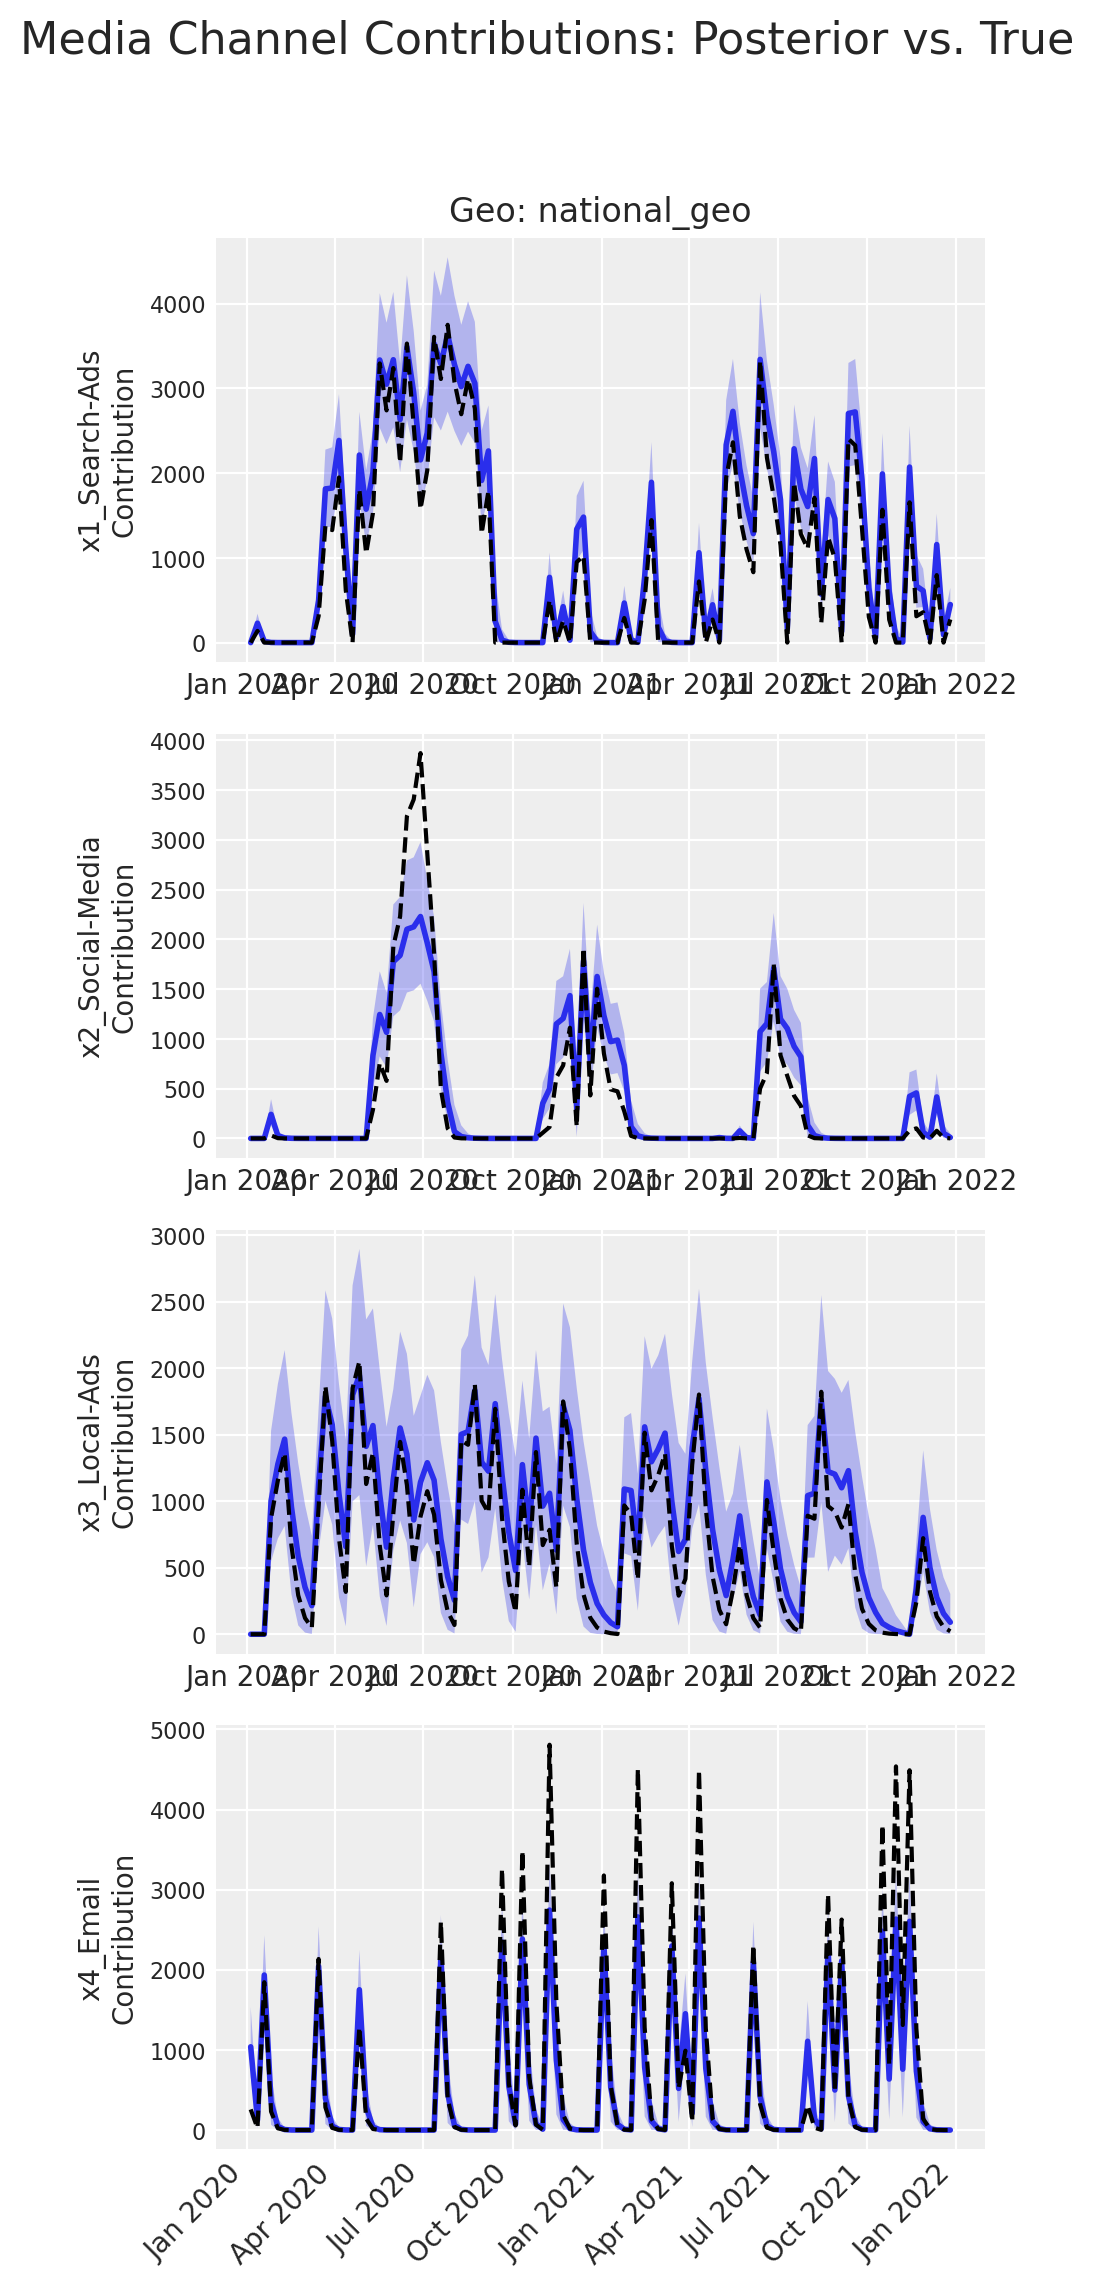

In [66]:
def plot_contributions_grid_with_truth(predicted_contributions_ds, true_contributions_ds):
    """
    Plots a grid of time series with rows = media_channel and cols = geo,
    shading between HDI bounds (lower and upper), and overlays true contributions.

    Parameters:
        predicted_contributions_ds (xarray.Dataset): Posterior Dataset with dims (hdi, geo, time, media_channel)
                                                     and coords hdi=["mean", "lower", "upper"].
        true_contributions_ds (xarray.Dataset): True contributions Dataset with dims
                                                (time, geo, media_channel) and variable "contribution".
    """
    da = predicted_contributions_ds["contribution"]

    geos = da.geo.values
    channels = da.media_channel.values
    time = pd.to_datetime(da.time.values)

    n_rows = len(channels)
    n_cols = len(geos)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 3 * n_rows), sharex=False, sharey=False)
    if n_rows == 1 and n_cols == 1:
        axs = np.array([[axs]])
    elif n_rows == 1:
        axs = np.array([axs])
    elif n_cols == 1:
        axs = np.array([[ax] for ax in axs])


    for i, channel in enumerate(channels):
        for j, geo in enumerate(geos):
            ax = axs[i, j]

            # Posterior mean + HDI
            mean = da.sel(hdi="mean", geo=geo, media_channel=channel)
            lower = da.sel(hdi="lower", geo=geo, media_channel=channel)
            upper = da.sel(hdi="upper", geo=geo, media_channel=channel)

            ax.plot(time, mean, label="Mean", linewidth=2)
            ax.fill_between(time, lower, upper, alpha=0.3, label="HDI (3%–97%)")

            # True contribution
            true_channel = f"contribution_{channel}"
            #try:
            truth = true_contributions_ds['contribution'].sel(media_channel = true_channel, geo= "geo_a" if geo  == "national_geo" else geo)
            truth = truth.sel(time=time)
            ax.plot(time, truth, linestyle="--", color="black", label="True", linewidth=1.5)
            #except KeyError:
            #    pass  # Skip if not found

            if i == 0:
                ax.set_title(f"Geo: {geo}", fontsize=12)
            if j == 0:
                ax.set_ylabel(f"{channel}\nContribution", fontsize=10)

            ax.grid(True)
            ax.xaxis.set_major_locator(mdates.AutoDateLocator())
            ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

    for ax in axs[-1]:
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    fig.suptitle("Media Channel Contributions: Posterior vs. True", fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
for i, (predicted_contributions_ds, true_contributions_ds) in enumerate(zip(
    predicted_contributions_ds_meridian_list,
    true_contributions_ds_list
), start=1):
    dataset_name = dataset_names[i - 1].split("_")[0]
    print(f"\n--- Plotting Contributions Grid with Truth ({dataset_name}) ---")

    true = true_contributions_ds.copy(deep=True)

    # Rename geo in the true dataset for small business (index 0)
    if i == 1 and "Local" in true.geo.values:
        true = true.assign_coords(geo=["geo_a"] if len(true.geo) == 1 else [
            "geo_a" if g == "Local" else g for g in true.geo.values
        ])

    plot_contributions_grid_with_truth(predicted_contributions_ds, true)

#### PyMC-Marketing


--- Plotting Contributions Grid with Truth (small) ---


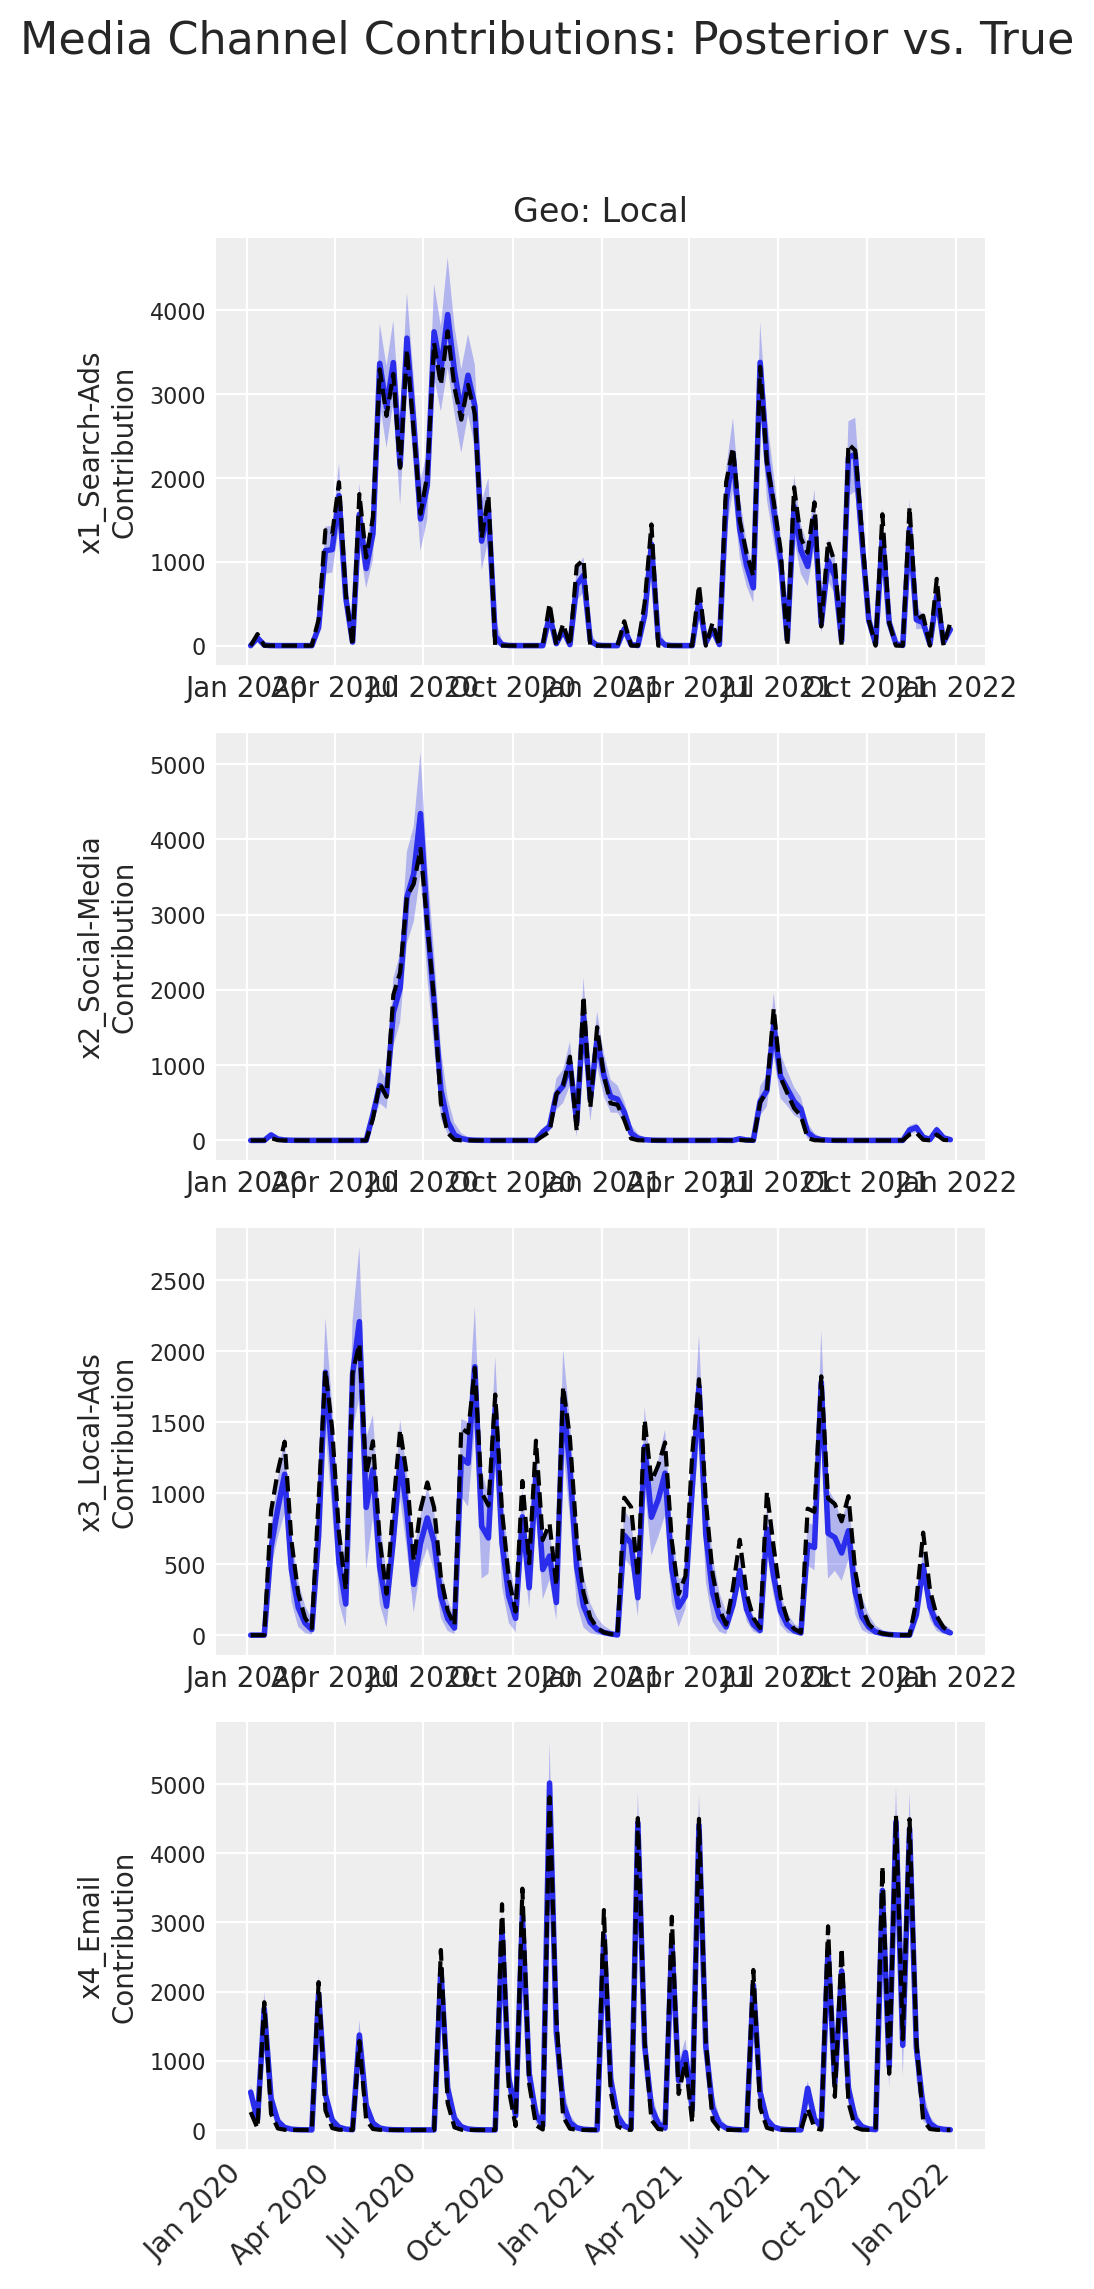

In [67]:
def plot_contributions_grid_with_truth(predicted_contributions_ds, true_contributions_ds):
    """
    Plots a grid of time series with rows = media_channel and cols = geo,
    shading between HDI bounds (3rd–97th percentiles), and overlays true contributions.

    Parameters:
        predicted_contributions_ds (xarray.Dataset): Dataset with dims (chain, draw, date, geo, channel)
        true_contributions_ds (xarray.Dataset): Dataset with vars like 'contribution_x1-seasonal-1'
                                                and dims (date, geo)
    """
    # Extract data
    da = predicted_contributions_ds

    # Collapse (chain, draw) into posterior samples axis
    stacked = da.stack(sample=("chain", "draw"))

    # Compute posterior mean and HDI bounds
    mean = stacked.mean(dim="sample")
    lower = stacked.quantile(0.03, dim="sample")
    upper = stacked.quantile(0.97, dim="sample")

    geos = da.coords["geo"].values
    channels = da.coords["channel"].values
    dates = pd.to_datetime(da.coords["date"].values)

    n_rows = len(channels)
    n_cols = len(geos)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 3 * n_rows), sharex=False, sharey=False)

    # Normalize axs to always be 2D
    if n_rows == 1 and n_cols == 1:
        axs = np.array([[axs]])
    elif n_rows == 1:
        axs = np.array([axs])
    elif n_cols == 1:
        axs = np.array([[ax] for ax in axs])

    for i, channel in enumerate(channels):
        for j, geo in enumerate(geos):
            ax = axs[i, j]

            mean_ts = mean.sel(geo=geo, channel=channel)
            lower_ts = lower.sel(geo=geo, channel=channel)
            upper_ts = upper.sel(geo=geo, channel=channel)

            ax.plot(dates, mean_ts, label="Mean", linewidth=2)
            ax.fill_between(dates, lower_ts, upper_ts, alpha=0.3, label="HDI (3%–97%)")

            # Plot true contributions
            true_var = f"contribution_{channel}"
            try:
                truth = true_contributions_ds['contribution'].sel(media_channel = true_var, geo=geo)
                truth = truth.sel(time=dates)
                ax.plot(dates, truth, linestyle="--", color="black", label="True", linewidth=1.5)
            except KeyError:
                pass  # skip if not found

            if i == 0:
                ax.set_title(f"Geo: {geo}", fontsize=12)
            if j == 0:
                ax.set_ylabel(f"{channel}\nContribution", fontsize=10)

            ax.grid(True)
            ax.xaxis.set_major_locator(mdates.AutoDateLocator())
            ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

    for ax in axs[-1]:
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    fig.suptitle("Media Channel Contributions: Posterior vs. True", fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

for i, (predicted_ds, true_ds) in enumerate(zip(
    predicted_contributions_ds_pymc_marketing_list,
    true_contributions_ds_list
), start=1):
    dataset_name = dataset_names[i - 1].split("_")[0]
    print(f"\n--- Plotting Contributions Grid with Truth ({dataset_name}) ---")

    # Deep copy both datasets
    pred = predicted_ds.copy(deep=True)
    true = true_ds.copy(deep=True)

    # ✅ Fix geo name in predicted dataset (not true!) for small dataset
    if i == 1 and "Local" in pred.geo.values:
        pred = pred.rename({'geo': 'geo'})  # ensures coordinate is named
        pred = pred.assign_coords(geo=("geo", ["national geo"]))

    plot_contributions_grid_with_truth(predicted_ds, true)


In [68]:
all_detailed_rows = []
summary_rows = []

def compute_smape_rows(predicted_ds, true_ds, lib_type, dataset_name):
    results = []

    def smape(a, f):
        return 100 * np.mean(2 * np.abs(f - a) / (np.abs(f) + np.abs(a) + 1e-8))

    if lib_type == "Meridian":
        pred_da = predicted_ds["contribution"].sel(hdi='mean')
        for geo in true_ds.coords["geo"].values:
            for channel in pred_da.coords["media_channel"].values:
                try:
                    pred = pred_da.sel(geo=geo if "national_geo" not in pred_da.coords["geo"].values else "national_geo", media_channel=channel)
                    try:
                        true = true_ds['contribution'].sel(media_channel=channel, geo=geo)
                    except KeyError:
                        true = true_ds['contribution'].sel(media_channel=f"contribution_{channel}", geo=geo)

                    pred_series = pd.Series(pred.values, index=pd.to_datetime(pred.coords["time"].values))
                    true_series = pd.Series(true.values, index=pd.to_datetime(true.coords["time"].values))

                    df = pd.DataFrame({"pred": pred_series, "true": true_series}).dropna()
                    df = df[df["true"] != 0]

                    if not df.empty:
                        smape_val = smape(df["true"], df["pred"])
                        results.append({
                            "Library": lib_type,
                            "Dataset": dataset_name,
                            "geo": geo,
                            "media_channel": channel,
                            "SMAPE (%)": round(smape_val, 2)
                        })

                except KeyError:
                    continue

    elif lib_type == "PyMC Marketing":
        pred_mean = predicted_ds.mean(dim=["chain", "draw"])
        for geo in predicted_ds.geo.values:
            # normalized_geo = "National" if geo in ["national_geo", "Local"] else geo
            for channel in predicted_ds.channel.values:
                try:
                    pred = pred_mean.sel(geo=geo, channel=channel)
                    try:
                        true = true_ds['contribution'].sel(media_channel=channel, geo=geo)
                    except KeyError:
                        true = true_ds['contribution'].sel(media_channel=f"contribution_{channel}", geo=geo)

                    pred_series = pd.Series(pred.values, index=pd.to_datetime(pred["date"].values))
                    true_series = pd.Series(true.values, index=pd.to_datetime(true["time"].values))

                    df = pd.DataFrame({"pred": pred_series, "true": true_series}).dropna()
                    df = df[df["true"] != 0]

                    if not df.empty:
                        smape_val = smape(df["true"], df["pred"])
                        results.append({
                            "Library": lib_type,
                            "Dataset": dataset_name,
                            "geo": geo,
                            "media_channel": channel,
                            "SMAPE (%)": round(smape_val, 2)
                        })

                except KeyError:
                    continue

    return results

# Meridian
for i, (predicted_ds, true_ds) in enumerate(zip(
    predicted_contributions_ds_meridian_list,
    true_contributions_ds_list
), start=1):
    dataset_name = dataset_names[i - 1].split("_")[0]
    true = true_ds.copy(deep=True)

    rows = compute_smape_rows(predicted_ds, true, lib_type="Meridian", dataset_name=dataset_name)
    all_detailed_rows.extend(rows)
    if rows:
        summary_rows.append({
            "Library": "Meridian",
            "Dataset": dataset_name,
            "Average SMAPE": round(np.mean([r["SMAPE (%)"] for r in rows]), 2)
        })

# PyMC Marketing
for i, (predicted_ds, true_ds) in enumerate(zip(
    predicted_contributions_ds_pymc_marketing_list,
    true_contributions_ds_list
), start=1):
    dataset_name = dataset_names[i - 1].split("_")[0]
    rows = compute_smape_rows(predicted_ds, true_ds, lib_type="PyMC Marketing", dataset_name=dataset_name)
    all_detailed_rows.extend(rows)
    if rows:
        summary_rows.append({
            "Library": "PyMC Marketing",
            "Dataset": dataset_name,
            "Average SMAPE": round(np.mean([r["SMAPE (%)"] for r in rows]), 2)
        })

# Convert to DataFrames
detailed_df = pd.DataFrame(all_detailed_rows)
summary_df = pd.DataFrame(summary_rows)

# === Format summary: pivot and clean ===
summary_df = summary_df.pivot(
    index="Dataset",
    columns="Library",
    values="Average SMAPE"
).reset_index()
summary_df.columns.name = None
summary_df = summary_df.round(2)

# === Format detailed: pivot and clean ===
detailed_df = detailed_df.pivot_table(
    index=["Dataset", "geo", "media_channel"],
    columns="Library",
    values="SMAPE (%)"
).reset_index()
detailed_df.columns.name = None
detailed_df = detailed_df.round(2)

# Display
print("\n=== Summary: Average SMAPE per Dataset ===")
display(summary_df)

pd.set_option('display.max_rows', None)  
print("\n=== Detailed SMAPE by Dataset, Geo, and Channel ===")
display(detailed_df)



=== Summary: Average SMAPE per Dataset ===


,Dataset,Meridian,PyMC Marketing
0,small,72.56,64.72



=== Detailed SMAPE by Dataset, Geo, and Channel ===


,Dataset,geo,media_channel,Meridian,PyMC Marketing
0,small,Local,x1_Search-Ads,29.96,13.46
1,small,Local,x2_Social-Media,126.53,103.53
2,small,Local,x3_Local-Ads,52.03,28.41
3,small,Local,x4_Email,81.70,113.48


In [69]:
all_mape_rows = []
mape_summary_rows = []

def compute_mape_rows(predicted_ds, true_ds, lib_type, dataset_name):
    results = []

    def mape(a, f):
        return 100 * np.mean(np.abs((a - f) / (a + 1e-8)))  # Avoid divide-by-zero

    if lib_type == "Meridian":
        pred_da = predicted_ds["contribution"].sel(hdi='mean')
        for geo in true_ds.coords["geo"].values:
            for channel in pred_da.coords["media_channel"].values:
                try:
                    pred = pred_da.sel(geo=geo if "national_geo" not in pred_da.coords["geo"].values else "national_geo", media_channel=channel)
                    try:
                        true = true_ds['contribution'].sel(media_channel=channel, geo=geo)
                    except KeyError:
                        true = true_ds['contribution'].sel(media_channel=f"contribution_{channel}", geo=geo)

                    pred_series = pd.Series(pred.values, index=pd.to_datetime(pred.coords["time"].values))
                    true_series = pd.Series(true.values, index=pd.to_datetime(true.coords["time"].values))

                    df = pd.DataFrame({"pred": pred_series, "true": true_series}).dropna()
                    df = df[df["true"] != 0]

                    if not df.empty:
                        mape_val = mape(df["true"], df["pred"])
                        results.append({
                            "Library": lib_type,
                            "Dataset": dataset_name,
                            "geo": geo,
                            "media_channel": channel,
                            "MAPE (%)": round(mape_val, 2)
                        })

                except KeyError:
                    continue

    elif lib_type == "PyMC Marketing":
        pred_mean = predicted_ds.mean(dim=["chain", "draw"])
        for geo in predicted_ds.geo.values:
            for channel in predicted_ds.channel.values:
                try:
                    pred = pred_mean.sel(geo=geo, channel=channel)
                    try:
                        true = true_ds['contribution'].sel(media_channel=channel, geo=geo)
                    except KeyError:
                        true = true_ds['contribution'].sel(media_channel=f"contribution_{channel}", geo=geo)

                    pred_series = pd.Series(pred.values, index=pd.to_datetime(pred["date"].values))
                    true_series = pd.Series(true.values, index=pd.to_datetime(true["time"].values))

                    df = pd.DataFrame({"pred": pred_series, "true": true_series}).dropna()
                    df = df[df["true"] != 0]

                    if not df.empty:
                        mape_val = mape(df["true"], df["pred"])
                        results.append({
                            "Library": lib_type,
                            "Dataset": dataset_name,
                            "geo": geo,
                            "media_channel": channel,
                            "MAPE (%)": round(mape_val, 2)
                        })

                except KeyError:
                    continue

    return results

# Meridian
for i, (predicted_ds, true_ds) in enumerate(zip(
    predicted_contributions_ds_meridian_list,
    true_contributions_ds_list
), start=1):
    dataset_name = dataset_names[i - 1]
    pred = predicted_ds.copy(deep=True)
    if i == 1 and "national geo" in pred.geo.values:
        pred = pred.assign_coords(geo=["Local"] if len(true.geo) == 1 else true.geo.values)

    rows = compute_mape_rows(pred, true_ds, lib_type="Meridian", dataset_name=dataset_name)
    all_mape_rows.extend(rows)
    if rows:
        mape_summary_rows.append({
            "Library": "Meridian",
            "Dataset": dataset_name,
            "Average MAPE": round(np.mean([r["MAPE (%)"] for r in rows]), 2)
        })

# PyMC Marketing
for i, (predicted_ds, true_ds) in enumerate(zip(
    predicted_contributions_ds_pymc_marketing_list,
    true_contributions_ds_list
), start=1):
    dataset_name = dataset_names[i - 1]
    rows = compute_mape_rows(predicted_ds, true_ds, lib_type="PyMC Marketing", dataset_name=dataset_name)
    all_mape_rows.extend(rows)
    if rows:
        mape_summary_rows.append({
            "Library": "PyMC Marketing",
            "Dataset": dataset_name,
            "Average MAPE": round(np.mean([r["MAPE (%)"] for r in rows]), 2)
        })

# Convert to DataFrames
mape_detailed_df = pd.DataFrame(all_mape_rows)
mape_summary_df = pd.DataFrame(mape_summary_rows)

# === Format summary: pivot and clean ===
mape_summary_df = mape_summary_df.pivot(
    index="Dataset",
    columns="Library",
    values="Average MAPE"
).reset_index()
mape_summary_df.columns.name = None
mape_summary_df = mape_summary_df.round(2)

# === Format detailed: pivot and clean ===
mape_detailed_df = mape_detailed_df.pivot_table(
    index=["Dataset", "geo", "media_channel"],
    columns="Library",
    values="MAPE (%)"
).reset_index()
mape_detailed_df.columns.name = None
mape_detailed_df = mape_detailed_df.round(2)

# Display
print("\n=== Summary: Average MAPE per Dataset ===")
display(mape_summary_df)

pd.set_option('display.max_rows', None)  
print("\n=== Detailed MAPE by Dataset, Geo, and Channel ===")
display(mape_detailed_df)



=== Summary: Average MAPE per Dataset ===


,Dataset,Meridian,PyMC Marketing
0,small_business,37451.98,30639.04



=== Detailed MAPE by Dataset, Geo, and Channel ===


,Dataset,geo,media_channel,Meridian,PyMC Marketing
0,small_business,Local,x1_Search-Ads,38.60,12.17
1,small_business,Local,x2_Social-Media,149015.70,106869.45
2,small_business,Local,x3_Local-Ads,165.80,24.44
3,small_business,Local,x4_Email,587.83,15650.12


## Bias Measure

**Total absolute reconstruction error and scaled root mean squared error**

In [70]:
from mmm_param_recovery.evaluation import compute_error_measure, meridian_to_contribution_xr, pymc_marketing_to_contribution_xr

In [71]:
# FIXME: this somehow gets overrident and needs to be fixed properly
pymc_mmm_models = all_models['PyMC-Marketing - nutpie']

In [72]:
biases = []
abs_errs = []

for idx, (meridian_model, mmm_model, true_ds) in enumerate(zip(meridian_models, pymc_mmm_models, true_contributions_ds_list)):
    true_ds = (
        true_ds
        .rename({"time":"date", "media_channel":"channel"})
        .assign_coords({"channel":lambda x: [xi.split("contribution_",1)[1] for xi in x.coords["channel"].values]})
    )
    contribution_data = []
    contribution_data.append(meridian_to_contribution_xr(meridian_model, true_ds))
    contribution_data.append(pymc_marketing_to_contribution_xr(mmm_model.idata.posterior))
    contribution_xr = xr.concat(contribution_data, dim=xr.Variable("model", ["Meridian", "PyMC-Marketing"]))
    biases.append(
        compute_error_measure(
            contribution_xr,
            true_ds
        ).quantile([0.04, 0.5, 0.96], dim=["geo", "chain", "draw", "channel"]))
    abs_errs.append(
        np.sqrt(compute_error_measure(
            contribution_xr,
            true_ds,
            error_measure="srmse"
        ).mean(["channel", "geo"]) / true_ds.mean(["date", "channel", "geo"])).quantile([0.04, 0.5, 0.96], dim=["chain", "draw"]))
biases = xr.concat(biases, xr.Variable("dataset",dataset_names))
abs_errs = xr.concat(abs_errs, xr.Variable("dataset",dataset_names))

In [73]:
from great_tables import GT, style, loc

In [74]:
recon = (biases.to_dataframe().join(abs_errs.to_dataframe(), lsuffix="_bias", rsuffix="_abs_error")
    .reset_index()
    .pivot(index=["dataset", "model"], columns="quantile", values=["contribution_bias", "contribution_abs_error"])
   .reset_index()
)

recon.columns = recon.columns.map(lambda x: f'{x[0]}_{x[1]}'.replace(".", "_"))
recon.rename(columns={"dataset_":"dataset", "model_":"model"}, inplace=True)
recon["dataset"] = recon["dataset"].map(lambda x: x.replace("_", " ").title()).values

GT(recon,
   groupname_col="dataset",
   rowname_col="model"
  ).tab_spanner(
    label = "Avg. Error", columns=["contribution_bias_0_5", "contribution_bias_0_04", "contribution_bias_0_96"]
).tab_spanner(
    label = "Scaled RMSE", columns=["contribution_abs_error_0_5", "contribution_abs_error_0_04", "contribution_abs_error_0_96"]
).cols_label(
    contribution_bias_0_5="Mean",
    contribution_bias_0_04 = "4%",
    contribution_bias_0_96 = "96%",
    contribution_abs_error_0_5 = "Mean",
    contribution_abs_error_0_04 = "4%",
    contribution_abs_error_0_96 = "96%"
).fmt_number(
    decimals=2,
)

GT(_tbl_data=          dataset           model  contribution_bias_0_04  \
0  Small Business        Meridian             -249.473627   
1  Small Business  PyMC-Marketing             -220.599132   

   contribution_bias_0_5  contribution_bias_0_96  contribution_abs_error_0_04  \
0              56.386074              496.986386                    12.495968   
1             -16.875299              105.826542                     4.927034   

   contribution_abs_error_0_5  contribution_abs_error_0_96  
0                   15.877438                    21.477355  
1                    6.726285                     9.179569  , _body=<great_tables._gt_data.Body object at 0x349c98770>, _boxhead=Boxhead([ColInfo(var='dataset', type=<ColInfoTypeEnum.row_group: 3>, column_label='dataset', column_align='left', column_width=None), ColInfo(var='model', type=<ColInfoTypeEnum.stub: 2>, column_label='model', column_align='left', column_width=None), ColInfo(var='contribution_bias_0_5', type=<ColInfoTypeEnum.default: 1>, column_label='Mean', column_align='right', column_width=None), ColInfo(var='contribution_bias_0_04', type=<ColInfoTypeEnum.default: 1>, column_label='4%', column_align='right', column_width=None), ColInfo(var='contribution_bias_0_96', type=<ColInfoTypeEnum.default: 1>, column_label='96%', column_align='right', column_width=None), ColInfo(var='contribution_abs_error_0_5', type=<ColInfoTypeEnum.default: 1>, column_label='Mean', column_align='right', column_width=None), ColInfo(var='contribution_abs_error_0_04', type=<ColInfoTypeEnum.default: 1>, column_label='4%', column_align='right', column_width=None), ColInfo(var='contribution_abs_error_0_96', type=<ColInfoTypeEnum.default: 1>, column_label='96%', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x431fc08c0>, _spanners=Spanners([SpannerInfo(spanner_id='Avg. Error', spanner_level=0, spanner_label='Avg. Error', spanner_units=None, spanner_pattern=None, vars=['contribution_bias_0_5', 'contribution_bias_0_04', 'contribution_bias_0_96'], built=None), SpannerInfo(spanner_id='Scaled RMSE', spanner_level=0, spanner_label='Scaled RMSE', spanner_units=None, spanner_pattern=None, vars=['contribution_abs_error_0_5', 'contribution_abs_error_0_04', 'contribution_abs_error_0_96'], built=None)]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x431c925d0>, _formats=[<great_tables._gt_data.FormatInfo object at 0x5c2fd72f0>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=Options